In [1]:
import os
import gc
import numpy as np
import pandas as pd

import json
import math
import sys
import time
from datetime import datetime
from typing import Tuple, List

import cv2
import matplotlib.pyplot as plt
import sklearn.metrics
from PIL import Image

from matplotlib.axes import Axes
from matplotlib import animation, rc
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import plot, init_notebook_mode
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

import seaborn as sns
from pyquaternion import Quaternion
from tqdm import tqdm

from lyft_dataset_sdk.utils.map_mask import MapMask
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from pathlib import Path

import struct
from abc import ABC, abstractmethod
from functools import reduce
from typing import Tuple, List, Dict
import copy

In [2]:
DATA_PATH = '/home/vignesh/workspace/lyft_3d/data/proper/3d-object-detection-for-autonomous-vehicles/'

In [3]:
train = pd.read_csv(DATA_PATH + 'train.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')     


In [4]:
object_columns = ['sample_id', 'object_id', 'center_x', 'center_y', 'center_z',
                  'width', 'length', 'height', 'yaw', 'class_name']
objects = []
for sample_id, ps in tqdm(train.values[:]):
    object_params = ps.split()
    n_objects = len(object_params)
    for i in range(n_objects // 8):
        x, y, z, w, l, h, yaw, c = tuple(object_params[i * 8: (i + 1) * 8])
        objects.append([sample_id, i, x, y, z, w, l, h, yaw, c])
train_objects = pd.DataFrame(
    objects,
    columns = object_columns
)

100%|██████████| 22680/22680 [00:06<00:00, 3404.33it/s]


In [5]:
numerical_cols = ['object_id', 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw']
train_objects[numerical_cols] = np.float32(train_objects[numerical_cols].values)

In [6]:
train_objects.head()

,sample_id,object_id,center_x,center_y,center_z,width,length,height,yaw,class_name
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,0.0,2680.282959,698.196899,-18.047768,2.064,5.488,2.053,2.604164,car
1,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,1.0,2691.997559,660.801636,-18.674259,1.818,4.570,1.608,-0.335176,car
2,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2.0,2713.607422,694.403503,-18.589972,1.779,4.992,1.620,2.579456,car
3,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,3.0,2679.986816,706.910156,-18.349594,1.798,3.903,1.722,2.586166,car
4,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,4.0,2659.352051,719.417480,-18.442999,1.936,4.427,1.921,2.601799,car


In [7]:
lyft_dataset = LyftDataset(data_path=DATA_PATH, json_path=DATA_PATH+'test_data')

JSON file instance.json missing, using empty list
JSON file sample_annotation.json missing, using empty list
9 category,
17 attribute,
4 visibility,
0 instance,
8 sensor,
168 calibrated_sensor,
219744 ego_pose,
218 log,
218 scene,
27468 sample,
219744 sample_data,
0 sample_annotation,
1 map,
Done loading in 7.8 seconds.
Reverse indexing ...
Done reverse indexing in 2.8 seconds.


In [8]:
my_scene = lyft_dataset.scene[0]
my_scene

{'log_token': '38844b35b1641a0d193f96efdcb8a39aa6fa023f2335a37415fb59699c32d548',
 'last_sample_token': 'f642637c9f642626e9608a7aaf6348e63c2dab7e76be90da219b227b449dc9de',
 'first_sample_token': 'f2cdcd4da1f66aba83db988bf453912583dabd4e6b6a379994a8edc490e39655',
 'name': 'host-a004-lidar0-1233944976297786786-1233945001198600096',
 'nbr_samples': 126,
 'description': '',
 'token': '38844b35b1641a0d193f96efdcb8a39aa6fa023f2335a37415fb59699c32d548'}

In [9]:
def render_scene(index):
    my_scene = lyft_dataset.scene[index]
    my_sample_token = my_scene["first_sample_token"]
    lyft_dataset.render_sample(my_sample_token)

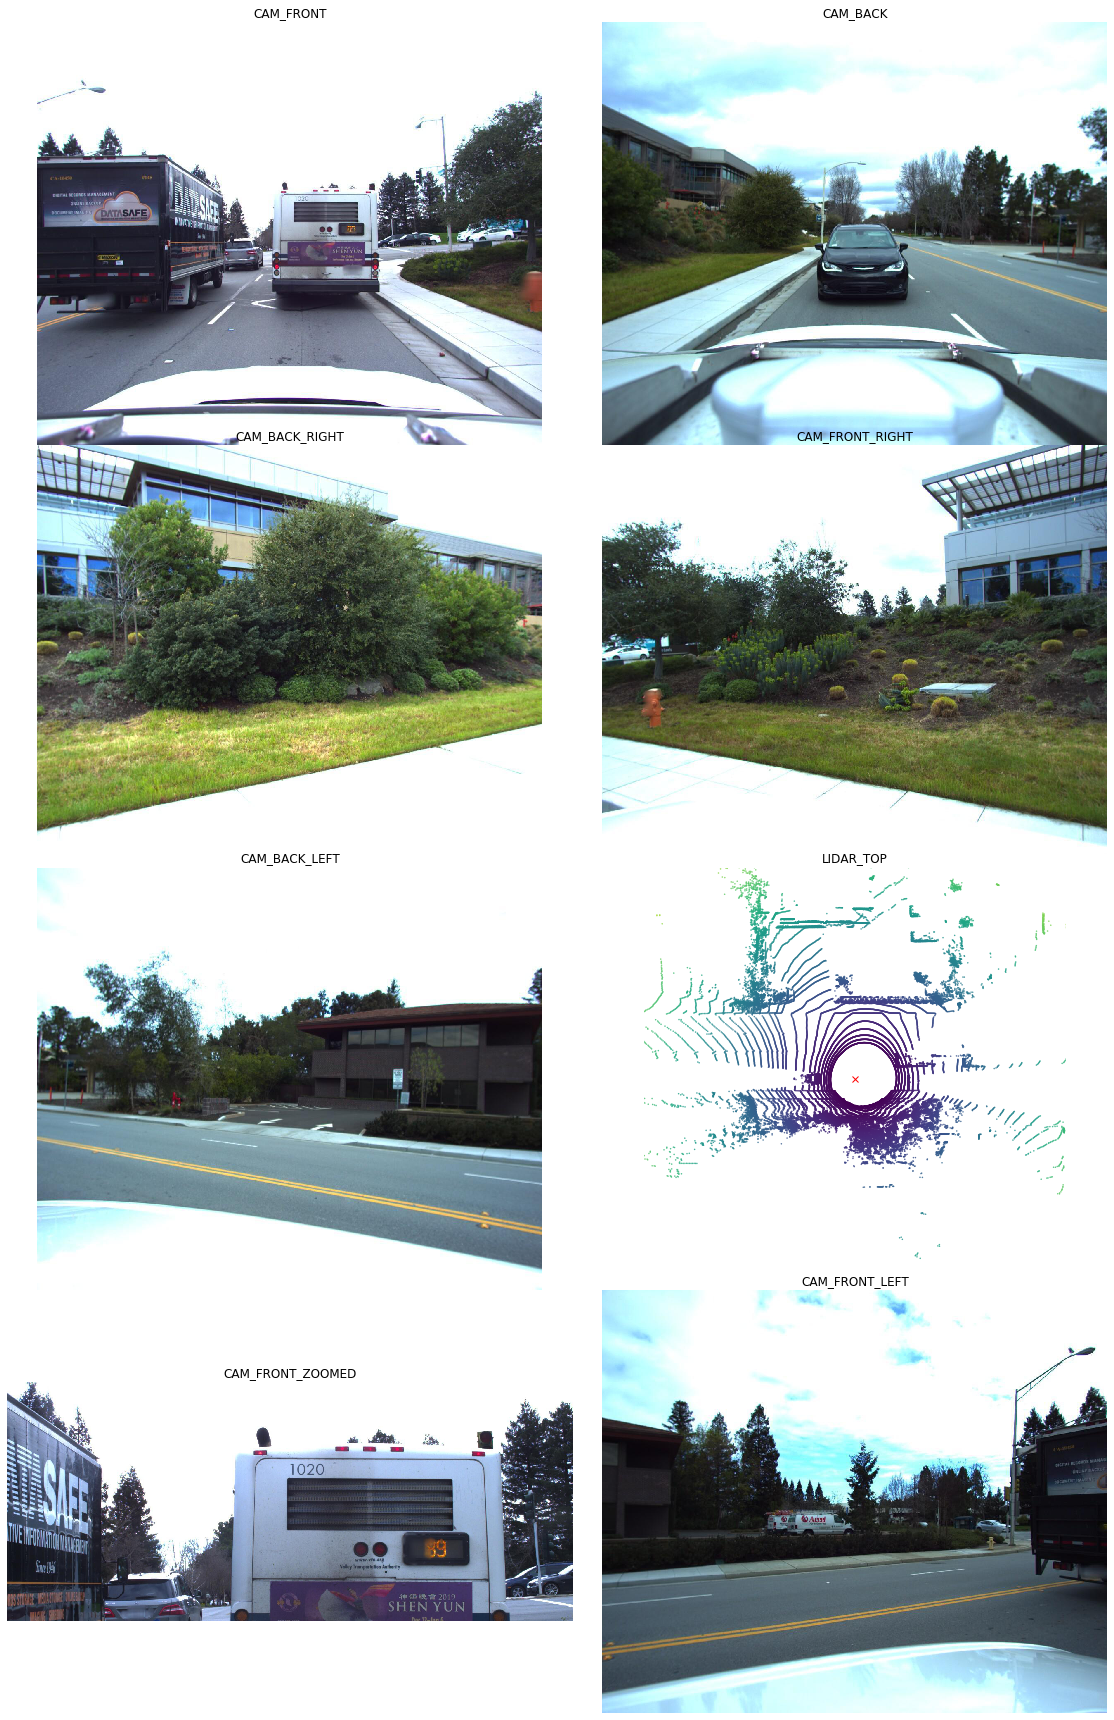

In [10]:
render_scene(0)

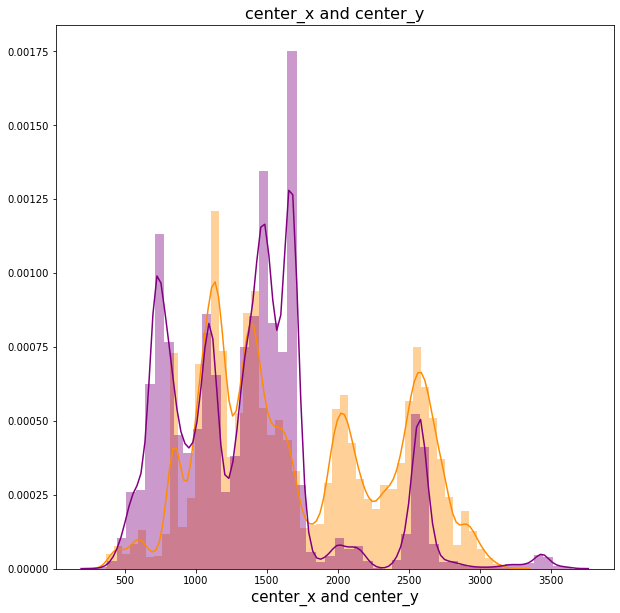

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['center_x'], color='darkorange', ax=ax).set_title('center_x and center_y', fontsize=16)
sns.distplot(train_objects['center_y'], color='purple', ax=ax).set_title('center_x and center_y', fontsize=16)
plt.xlabel('center_x and center_y', fontsize=15)
plt.show()


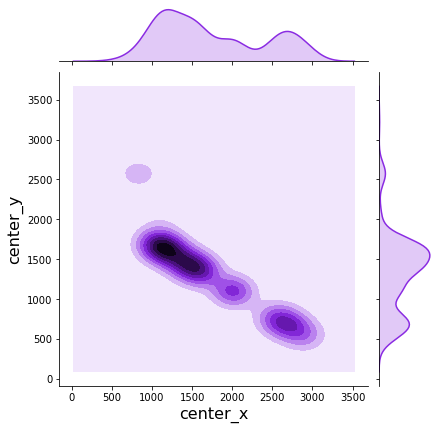

In [12]:
new_train_objects = train_objects.query('class_name == "car"')
plot = sns.jointplot(x=new_train_objects['center_x'][:1000], y=new_train_objects['center_y'][:1000], kind='kde', color='blueviolet')
plot.set_axis_labels('center_x', 'center_y', fontsize=16)
plt.show()

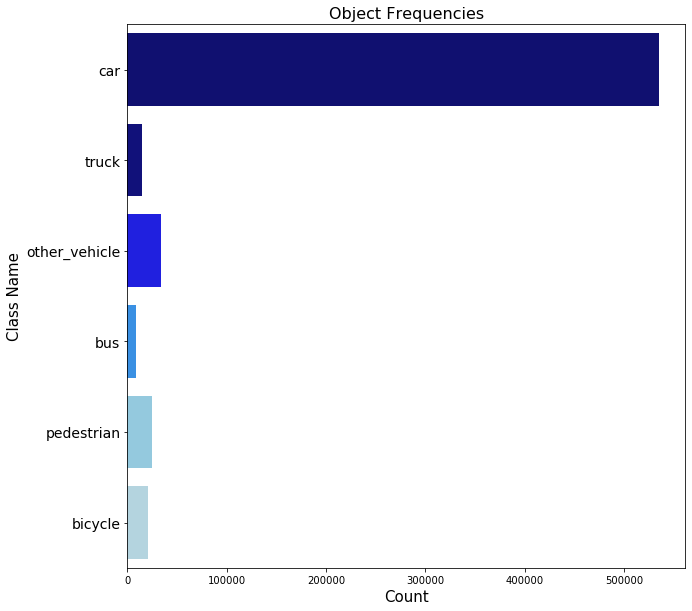

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.countplot(y="class_name", data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                     palette=['navy', 'darkblue', 'blue', 'dodgerblue', 'skyblue', 'lightblue']).set_title('Object Frequencies', fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Count", fontsize=15)
plt.ylabel("Class Name", fontsize=15)
plt.show(plot)


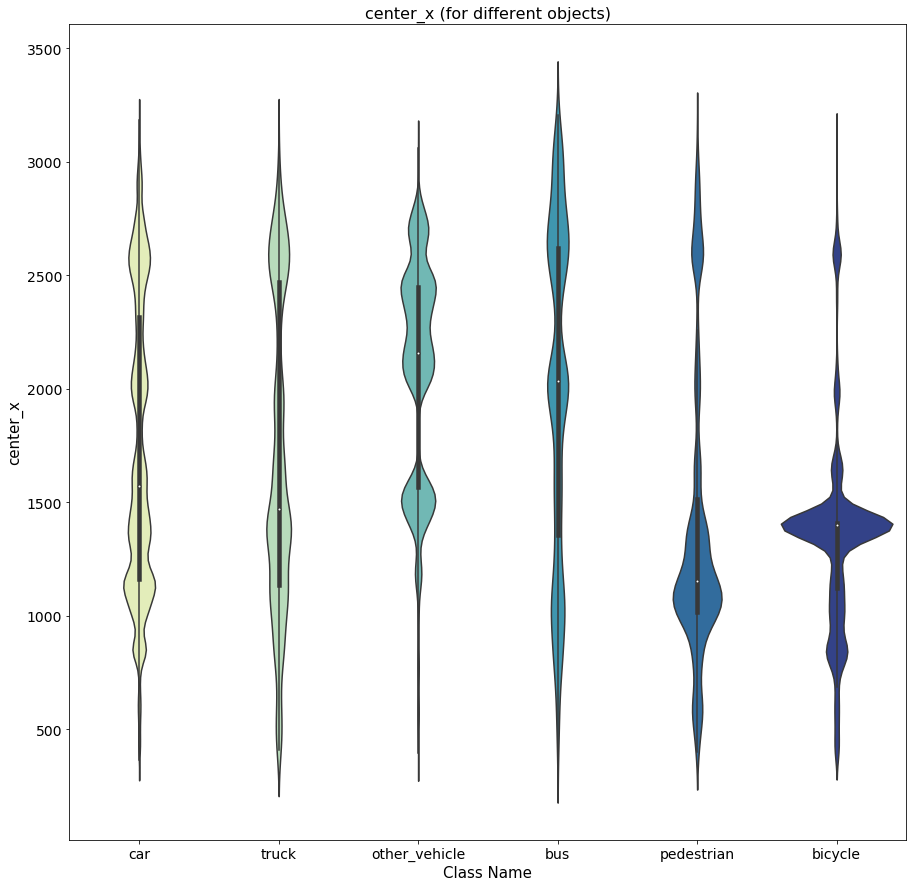

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="class_name", y="center_x",
                      data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                      palette='YlGnBu',
                      split=True, ax=ax).set_title('center_x (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_x", fontsize=15)
plt.show(plot)